# Masking

In [31]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from loguru import logger
import kernex as kex
from jaxsw._src.masks import Mask

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}" +
        f" {quantity.dtype}"
    )

```python
mask: GeoDataFrame = ...
mask: Array = polygon_to_array(mask)

mask_q

```

psi --- q --- psi --- q --- psi --- q --- psi
land          water         water        land
false.        true.         true.        false
       true          true.         true

psi --- q --- psi --- q --- psi --- q --- psi
land          water         water        land
false.        true.         true.        false
       true          true.         true

## Initialization From Psi

**Examples**:

* Rectangular Domain
* Channel Flow
* Island
* Mediterranean


**Caveats**:

* Single Pixel Island...

In [33]:


def init_mask_psi_rect(n: int=10):
    mask = jnp.ones((n,n))
    mask = mask.at[0].set(0.0)
    mask = mask.at[-1].set(0.0)
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    masks = Mask.init_mask(mask, "psi")
    return masks

def init_mask_psi_island(n: int=10):
    mask = jnp.ones((n,n))
    mask = mask.at[0].set(0.0)
    mask = mask.at[-1].set(0.0)
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    mask = mask.at[4:-4,4:-4].set(0.0)
    masks = Mask.init_mask(mask, "psi")
    return masks

def init_mask_psi_channel(n: int=10):
    mask = jnp.ones((n,3*n//4))
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    masks = Mask.init_mask(mask, "psi")
    return masks

def init_mask_q_weird(n: int=10):
    mask = jnp.ones((n,n))
    mask = mask.at[1,0].set(0.0)
    mask = mask.at[n-1,2].set(0.0)
    mask = mask.at[0,n-2].set(0.0)
    mask = mask.at[1,n-2].set(0.0)
    mask = mask.at[0,n-1].set(0.0)
    mask = mask.at[1,n-1].set(0.0)
    mask = mask.at[2,n-1].set(0.0)
    masks = Mask.init_mask(mask, "q")
    return masks

In [34]:
n = 6
masks = init_mask_q_weird(n)

# n = 10
# masks = init_mask_psi_island(n)





## Visualization

### StreamFunction

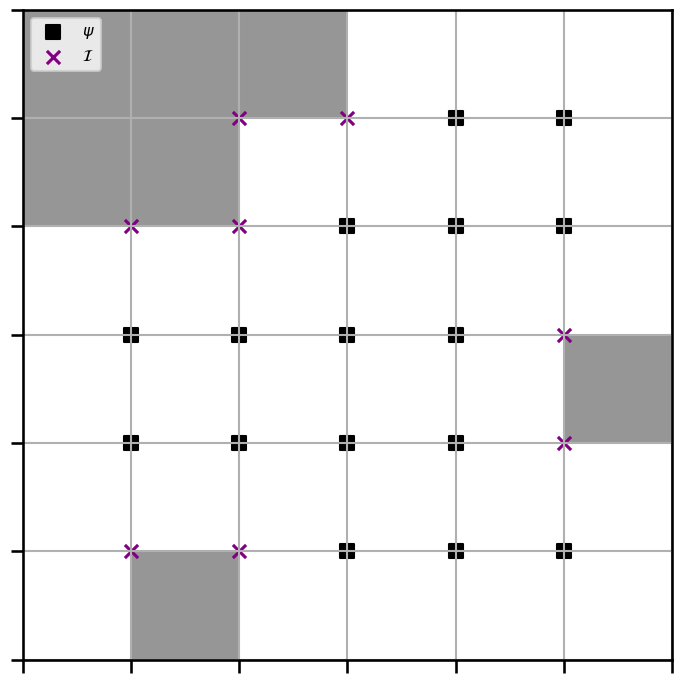

In [36]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(masks.q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-0.5,n+0.5)), ax.set_yticks(np.arange(-0.5,n+0.5))

s = 90
s2 = 130

# PLOT STREAM FUNCTION
psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = jnp.argwhere(masks.psi.values.squeeze())
ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\\psi$', color='black')

# PLOT BOUNDARIES
ax.scatter(psi_xmin+1+masks.psi.irrbound_xids,psi_ymin+1+masks.psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')



ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Potential Vorticity

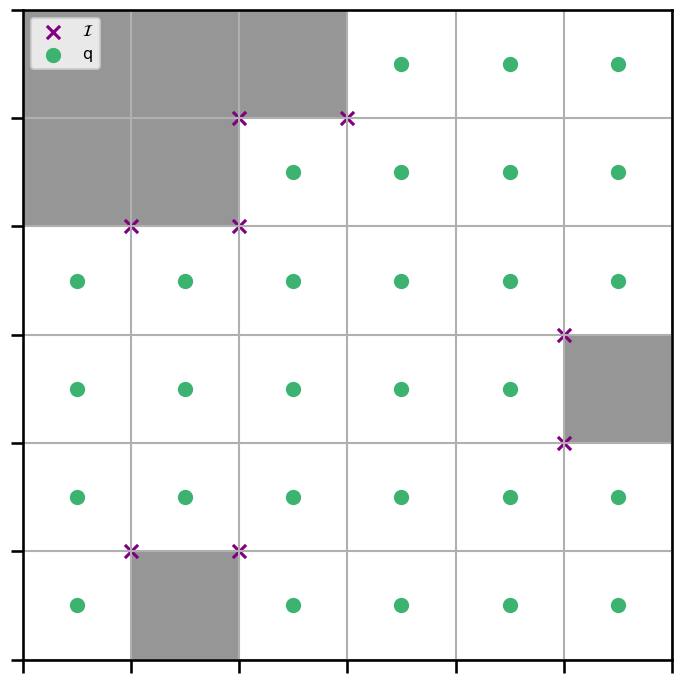

In [37]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(masks.q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130

# # PLOT STREAM FUNCTION
# psi_xmin, psi_ymin = -.5, -.5
# mask_psi_ids = jnp.argwhere(masks.psi.squeeze())
# ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
#           s=s, marker='s', label='$\\psi$', color='black')

# PLOT BOUNDARIES
ax.scatter(psi_xmin+1+masks.psi.irrbound_xids,psi_ymin+1+masks.psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# PLOT POTENTIAL VORTICITY
s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = jnp.argwhere(masks.q.values.squeeze())
ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='mediumseagreen')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Zonal Velocity

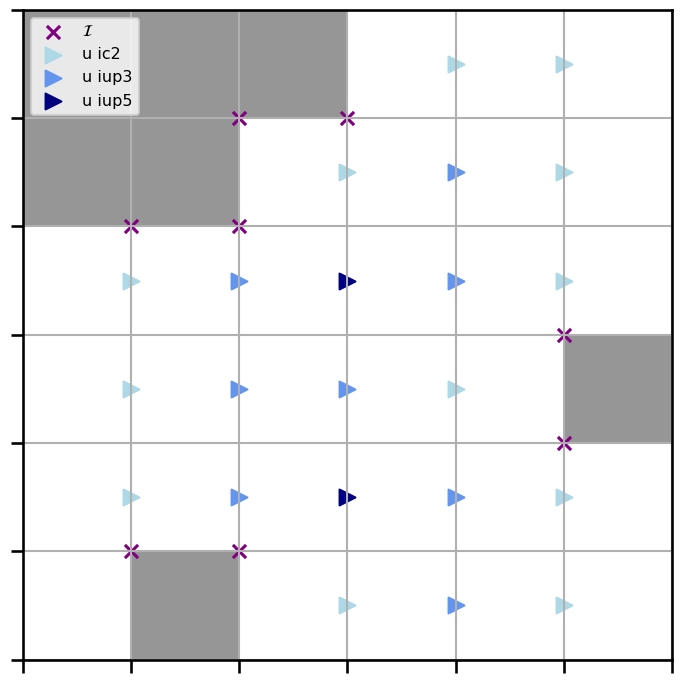

In [38]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(masks.q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130


# PLOT BOUNDARIES
ax.scatter(psi_xmin+1+masks.psi.irrbound_xids,psi_ymin+1+masks.psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# # PLOT STREAM FUNCTION
# psi_xmin, psi_ymin = -.5, -.5
# mask_psi_ids = jnp.argwhere(masks.psi.squeeze())
# ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
#           s=s, marker='s', label='$\\psi$', color='black')

# # PLOT POTENTIAL VORTICITY
# s = 90
# s2 = 130
# q_xmin, q_ymin = 0, 0
# mask_q_ids = jnp.argwhere(masks.q.squeeze())
# ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
#             s=s, marker='o', label='q', color='tab:red')

# # PLOT POTENTIAL VORTICITY
# s = 90
# s2 = 130
# q_xmin, q_ymin = 0, 0
# mask_q_ids = jnp.argwhere(masks.q.squeeze())
# ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
#             s=s, marker='o', label='q', color='tab:red')


# PLOT ZONAL VELOCITY
u_xmin, u_ymin = -.5, 0
mask_u_ids = jnp.argwhere(masks.u.distbound1.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(masks.u.distbound2.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(masks.u.distbound3plus.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Meridional Velocity

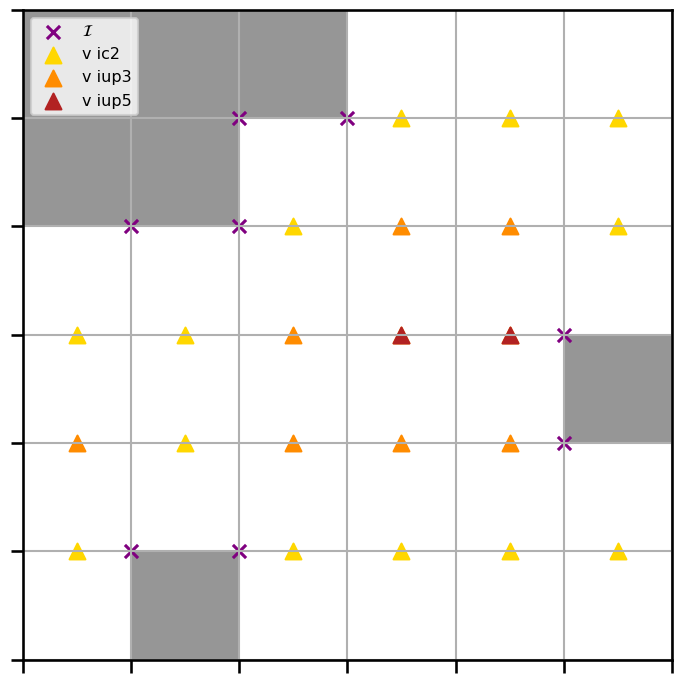

In [39]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(masks.q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130


# PLOT BOUNDARIES
ax.scatter(psi_xmin+1+masks.psi.irrbound_xids,psi_ymin+1+masks.psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# # PLOT STREAM FUNCTION
# psi_xmin, psi_ymin = -.5, -.5
# mask_psi_ids = jnp.argwhere(masks.psi.squeeze())
# ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
#           s=s, marker='s', label='$\\psi$', color='black')


# # PLOT POTENTIAL VORTICITY
# s = 90
# s2 = 130
# q_xmin, q_ymin = 0, 0
# mask_q_ids = jnp.argwhere(masks.q.squeeze())
# ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
#             s=s, marker='o', label='q', color='tab:red')

# # PLOT ZONAL VELOCITY
# u_xmin, u_ymin = .5, 0
# mask_u_ids = jnp.argwhere(masks.u_distbound1.squeeze())
# ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
#             s=s2, marker='>', label='u ic2', color='lightblue')
# mask_u_ids = jnp.argwhere(masks.u_distbound2.squeeze())
# ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
#             s=s2, marker='>', label='u iup3', color='cornflowerblue')
# mask_u_ids = jnp.argwhere(masks.u_distbound3plus.squeeze())
# ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
#             s=s2, marker='>', label='u iup5', color='navy')

# PLOT MERIDIONAL VELOCITY
v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(masks.v.distbound1.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(masks.v.distbound2plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(masks.v.distbound3plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Arakawa C-Grid

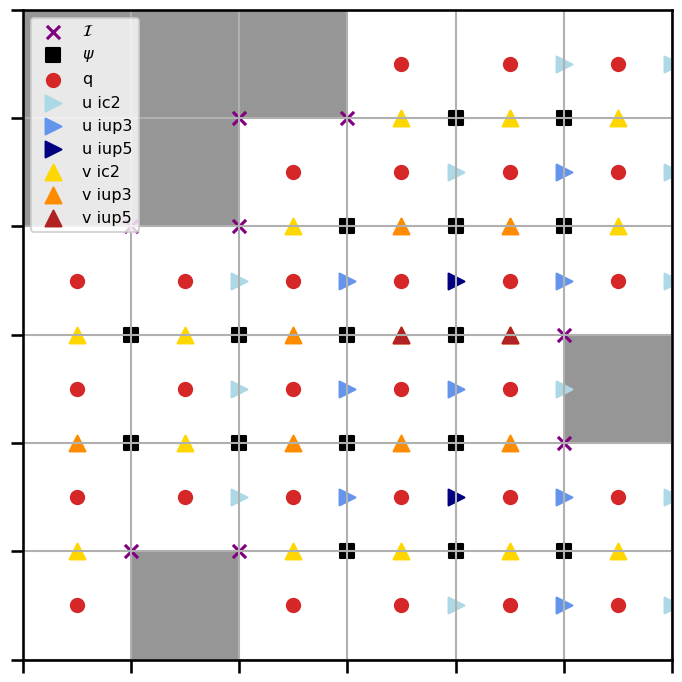

In [40]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(masks.q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130


# PLOT BOUNDARIES
ax.scatter(psi_xmin+1+masks.psi.irrbound_xids,psi_ymin+1+masks.psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# PLOT STREAM FUNCTION
psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = jnp.argwhere(masks.psi.values.squeeze())
ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\\psi$', color='black')


# PLOT POTENTIAL VORTICITY
s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = jnp.argwhere(masks.q.values.squeeze())
ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='tab:red')

# PLOT ZONAL VELOCITY
u_xmin, u_ymin = .5, 0
mask_u_ids = jnp.argwhere(masks.u.distbound1.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(masks.u.distbound2.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(masks.u.distbound3plus.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

# PLOT MERIDIONAL VELOCITY
v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(masks.v.distbound1.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(masks.v.distbound2plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(masks.v.distbound3plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()